In [1]:
!pip install -q tensorflow

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

if hasattr(tf, 'lite'):
    print("TensorFlow Lite is available!")
else:
    print("TensorFlow Lite is not available.")

TensorFlow version: 2.17.1
TensorFlow Lite is available!


In [3]:
import tensorflow_hub as hub

# Loading pre-trained pose estimation model MoveNet from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
print("Downloading the model...")
model = hub.load(MODEL_URL)
print("Model downloaded successfully!")


Model downloaded successfully!


In [4]:
# Wrapper class for the MoveNet model
class MovenetWrapper(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[1, 256, 256, 3], dtype=tf.int32, name="input")])
    def predict(self, inputs):
        return self.model.signatures['serving_default'](inputs)

# Wraping the MoveNet model
print("Wrapping the MoveNet model with corrected input shape...")
wrapped_model = MovenetWrapper(model)

Wrapping the MoveNet model with corrected input shape...


In [5]:
SAVED_MODEL_PATH = "saved_model"
tf.saved_model.save(
    wrapped_model,
    SAVED_MODEL_PATH,
    signatures={"serving_default": wrapped_model.predict}
)
print(f"Model saved with corrected input shape to {SAVED_MODEL_PATH}.")

Model saved with corrected input shape to saved_model.


In [6]:
# Converting the wrapped model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

print("Converting the model to TensorFlow Lite format...")
tflite_model = converter.convert()

TFLITE_MODEL_PATH = "pose_estimation_model.tflite"
with open(TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {TFLITE_MODEL_PATH}.")


Converting the model to TensorFlow Lite format...
TensorFlow Lite model saved to pose_estimation_model.tflite.


In [7]:
import numpy as np
import time

In [8]:
print("Loading the TensorFlow Lite model...")
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
print("Model loaded successfully!")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)


Loading the TensorFlow Lite model...
Model loaded successfully!
Input Details: [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 312, 'shape': array([ 1,  1, 17,  3], dtype=int32), 'shape_signature': array([ 1,  1, 17,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [9]:
# Creating dummy input image (256x256, normalized to [0, 255])
input_shape = input_details[0]['shape']
dummy_input = np.random.randint(0, 256, size=input_shape, dtype=np.int32)
print(f"Dummy input shape: {dummy_input.shape}")

# Setting input tensor
interpreter.set_tensor(input_details[0]['index'], dummy_input)

# Measuring inference time
print("Running inference...")
start_time = time.time()
interpreter.invoke()
end_time = time.time()

# Calculating inference time
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Inference completed in {inference_time:.2f} ms.")

# Output
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output Data:", output_data)

Dummy input shape: (1, 256, 256, 3)
Running inference...
Inference completed in 86.08 ms.
Output Data: [[[[0.19648397 0.4563321  0.00716328]
   [0.104017   0.49525955 0.01189626]
   [0.7634475  0.9746865  0.11240048]
   [0.27769083 0.4224572  0.04123418]
   [0.01591666 0.01784083 0.08152397]
   [0.8658039  0.9751027  0.10733252]
   [0.19138743 0.3593214  0.01532235]
   [0.51014507 0.5154996  0.03780413]
   [0.43992746 0.24502592 0.02691859]
   [0.64839906 0.45526436 0.01896723]
   [0.53066057 0.16359052 0.03020841]
   [0.7290013  0.5159169  0.02538856]
   [0.72678393 0.35072574 0.04015174]
   [0.80081266 0.49758732 0.02080124]
   [0.8790966  0.3702905  0.02531769]
   [0.9178514  0.50175107 0.01885101]
   [0.94674253 0.3919367  0.01529966]]]]


In [10]:
# Saving the results
results = f"""
Model: TensorFlow Lite Pose Estimation Model (MoveNet)
Input Shape: {input_shape}
Inference Time: {inference_time:.2f} ms
Output Data (Sample): {output_data}
"""

RESULTS_FILE = "model_performance_results.txt"
with open(RESULTS_FILE, "w") as file:
    file.write(results)

print(f"Results saved to {RESULTS_FILE}.")


Results saved to model_performance_results.txt.


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

Inference Time: 82.12 ms


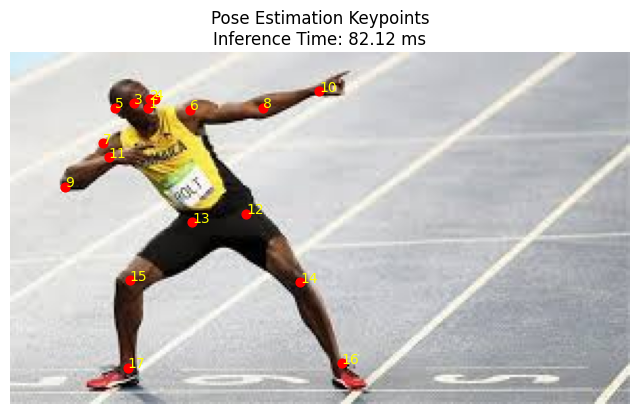

In [12]:
# Input image
image_path = "/content/images.jpg"  # Replace with the path to your input image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Resize the image to the model's required input size
input_image = cv2.resize(image_rgb, (256, 256))
input_image_normalized = np.array(input_image, dtype=np.int32).reshape(1, 256, 256, 3)

# Setting input tensor
interpreter.set_tensor(input_details[0]['index'], input_image_normalized)

start_time = time.time()
interpreter.invoke()
end_time = time.time()

# Calculate inference time
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Inference Time: {inference_time:.2f} ms")

# Output
output_data = interpreter.get_tensor(output_details[0]['index'])[0][0]

# Denormalize keypoints back to original image size
height, width, _ = image.shape
keypoints = []
for y, x, confidence in output_data:
    keypoints.append((int(x * width), int(y * height)))

# Plot the image with keypoints
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
for i, (x, y) in enumerate(keypoints):
    plt.scatter(x, y, c='red', s=40, label=f'Keypoint {i+1}' if i == 0 else "")
    plt.text(x, y, f'{i+1}', color='yellow', fontsize=10)  # Labeling keypoints
plt.axis('off')
plt.title(f"Pose Estimation Keypoints\nInference Time: {inference_time:.2f} ms")
plt.show()

In [13]:
from tabulate import tabulate

keypoint_mapping = [
    ["1", "Nose"],
    ["2", "Left Eye"],
    ["3", "Right Eye"],
    ["4", "Left Ear"],
    ["5", "Right Ear"],
    ["6", "Left Shoulder"],
    ["7", "Right Shoulder"],
    ["8", "Left Elbow"],
    ["9", "Right Elbow"],
    ["10", "Left Wrist"],
    ["11", "Right Wrist"],
    ["12", "Left Hip"],
    ["13", "Right Hip"],
    ["14", "Left Knee"],
    ["15", "Right Knee"],
    ["16", "Left Ankle"],
    ["17", "Right Ankle"]
]

# Showing mappings for detected key points
table = tabulate(keypoint_mapping, headers=["Keypoint Number", "Body Part"], tablefmt="grid")
print(table)


+-------------------+----------------+
|   Keypoint Number | Body Part      |
+===================+================+
|                 1 | Nose           |
+-------------------+----------------+
|                 2 | Left Eye       |
+-------------------+----------------+
|                 3 | Right Eye      |
+-------------------+----------------+
|                 4 | Left Ear       |
+-------------------+----------------+
|                 5 | Right Ear      |
+-------------------+----------------+
|                 6 | Left Shoulder  |
+-------------------+----------------+
|                 7 | Right Shoulder |
+-------------------+----------------+
|                 8 | Left Elbow     |
+-------------------+----------------+
|                 9 | Right Elbow    |
+-------------------+----------------+
|                10 | Left Wrist     |
+-------------------+----------------+
|                11 | Right Wrist    |
+-------------------+----------------+
|                12 | Lef